# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

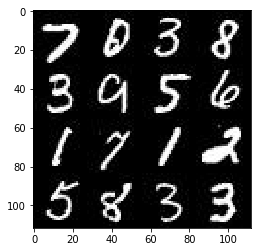

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

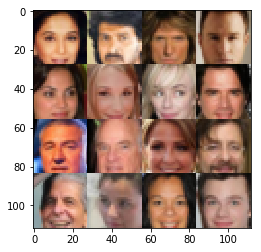

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 4, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*layer1, layer1)
        # 28*28*64
        
        layer2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2= tf.maximum(alpha*bn2, bn2)
        # 14*14*128
        
        layer3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 7*7*256
        
        layer4 = tf.layers.conv2d(relu3, 512, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(layer4, training=True)
        relu4 = tf.maximum(alpha*bn4, bn4)
        # 4*4*512
        
        layer5 = tf.layers.conv2d(relu4, 1024, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn5 = tf.layers.batch_normalization(layer5, training=True)
        relu5 = tf.maximum(alpha*bn5, bn5)
        # 2*2*1024
        
        flattened = tf.reshape(relu5, (-1, 2*2*2048))
        
        logit = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logit) 
        

    return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse = not is_train):
        
        layer1 = tf.layers.dense(z, 1*1*2048)
        layer1 = tf.reshape(layer1, (-1, 1, 1, 2048))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        # 1*1*2048
        
        layer2 = tf.layers.conv2d_transpose(layer1, 1024, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        # 2*2*1024
        
        layer3 = tf.layers.conv2d_transpose(layer2, 512, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        # 4*4*512
        
        layer4 = tf.layers.conv2d_transpose(layer3, 258, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(alpha * layer4, layer4)
        # 8*8*256
        
        layer5 = tf.layers.conv2d_transpose(layer4, 128, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer5 = tf.layers.batch_normalization(layer5, training=is_train)
        layer5 = tf.maximum(alpha * layer5, layer5)
        # 16*16*128
        
        layer6 = tf.layers.conv2d_transpose(layer5, 64, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer6 = tf.layers.batch_normalization(layer6, training=is_train)
        layer6 = tf.maximum(alpha * layer6, layer6)
        # 32*32*64
        
        logit = tf.layers.conv2d_transpose(layer6, out_channel_dim, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 64*64*3 
        
        logits = tf.image.resize_images(logit, (28, 28), align_corners=False)
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logit_real = discriminator(input_real, reuse=False)
    
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    step = 0
    
    samples, width, height, channels = data_shape
    
    real_input, z_input, l_r = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #batch_z = tf.truncated_normal([batch_size, z_dim])
                #batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images,
                                                 z_input: batch_z,
                                                 l_r: learning_rate})
                sess.run(g_train_opt, feed_dict={real_input: batch_images,
                                                 z_input: batch_z,
                                                 l_r: learning_rate})
                step += 1
                
                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % show_every == 0:
                    show_generator_output(sess, 16, z_input, channels, data_image_mode)
                    
        #saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 4.6263
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 4.5819
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 5.5855
Epoch 1/2... Discriminator Loss: 3.1240... Generator Loss: 0.0744
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 9.9451
Epoch 1/2... Discriminator Loss: 2.9929... Generator Loss: 0.0846
Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 5.6876
Epoch 1/2... Discriminator Loss: 0.5076... Generator Loss: 2.2732
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 3.9352
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 5.2583


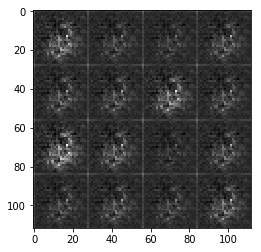

Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.3110
Epoch 1/2... Discriminator Loss: 0.5218... Generator Loss: 2.5749
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 2.0832
Epoch 1/2... Discriminator Loss: 0.4559... Generator Loss: 2.9475
Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.3742
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.2651
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 6.6940
Epoch 1/2... Discriminator Loss: 0.4570... Generator Loss: 3.3971
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 6.4976


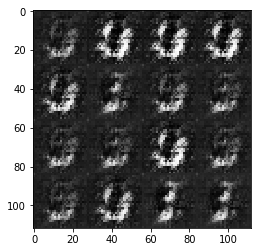

Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 3.5122
Epoch 1/2... Discriminator Loss: 0.4655... Generator Loss: 3.0873
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 3.2900
Epoch 1/2... Discriminator Loss: 0.4766... Generator Loss: 4.7904
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 2.8500
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 4.3444
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 2.9209
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.8691
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 2.0448


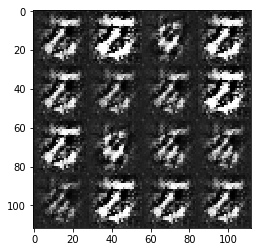

Epoch 1/2... Discriminator Loss: 0.5195... Generator Loss: 2.5995
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 0.4355... Generator Loss: 3.5780
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 6.5543
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 2.8414
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 4.8600
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 6.4690
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 3.7490
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 3.5002
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.2612


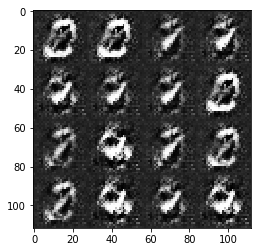

Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 3.2191
Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 3.6157
Epoch 1/2... Discriminator Loss: 0.4162... Generator Loss: 3.6722
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 4.6476
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 2.4451
Epoch 1/2... Discriminator Loss: 0.4952... Generator Loss: 5.2265
Epoch 1/2... Discriminator Loss: 0.4899... Generator Loss: 5.9146
Epoch 1/2... Discriminator Loss: 0.4291... Generator Loss: 5.1682
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 4.2406
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 3.5117


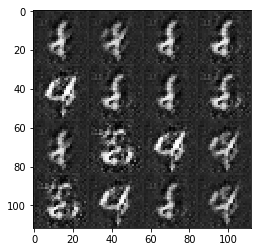

Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 4.0364
Epoch 1/2... Discriminator Loss: 0.4491... Generator Loss: 3.8989
Epoch 1/2... Discriminator Loss: 0.4968... Generator Loss: 6.6891
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.5532
Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 2.9867
Epoch 1/2... Discriminator Loss: 0.4564... Generator Loss: 2.7397
Epoch 1/2... Discriminator Loss: 0.6285... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 3.9511


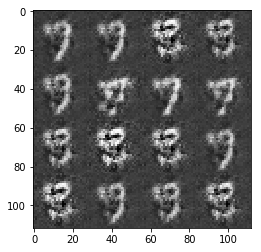

Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 4.5022
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 1.8856
Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.8963
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.1170
Epoch 1/2... Discriminator Loss: 0.4354... Generator Loss: 2.8041
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 3.5203
Epoch 1/2... Discriminator Loss: 0.7001... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 5.5668
Epoch 1/2... Discriminator Loss: 1.5521... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.5423


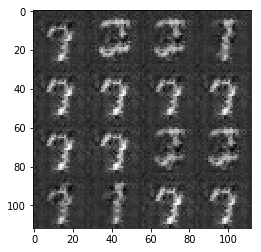

Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.4819
Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 4.2857
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 5.0701
Epoch 1/2... Discriminator Loss: 0.4060... Generator Loss: 2.8774
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 2.7696
Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 5.3776
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 2.0216
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 5.8722
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 4.5366
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 5.3104


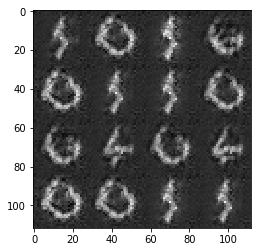

Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 4.2277
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 3.3092
Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 3.6355
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 6.1100
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 3.5881
Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 3.4285
Epoch 1/2... Discriminator Loss: 0.3581... Generator Loss: 4.6917
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 5.3937
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 3.3395
Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 3.6652


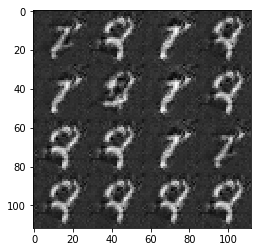

Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 1.9629
Epoch 1/2... Discriminator Loss: 0.4554... Generator Loss: 3.1835
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 2.5521
Epoch 2/2... Discriminator Loss: 0.4004... Generator Loss: 2.8176
Epoch 2/2... Discriminator Loss: 0.3996... Generator Loss: 3.2150
Epoch 2/2... Discriminator Loss: 0.3846... Generator Loss: 3.2535
Epoch 2/2... Discriminator Loss: 0.3816... Generator Loss: 3.5448
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 3.6020
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 3.3567
Epoch 2/2... Discriminator Loss: 0.4514... Generator Loss: 8.6268


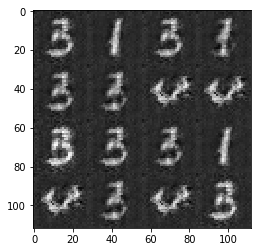

Epoch 2/2... Discriminator Loss: 0.4034... Generator Loss: 3.3089
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 3.9318
Epoch 2/2... Discriminator Loss: 0.3938... Generator Loss: 3.0778
Epoch 2/2... Discriminator Loss: 0.4600... Generator Loss: 3.0026
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.5317
Epoch 2/2... Discriminator Loss: 0.3826... Generator Loss: 3.3689
Epoch 2/2... Discriminator Loss: 0.3713... Generator Loss: 4.6172
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 5.2641
Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 3.4994
Epoch 2/2... Discriminator Loss: 0.3646... Generator Loss: 4.0233


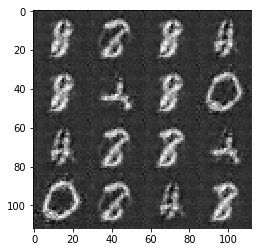

Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.2132
Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 3.6955
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 4.2319
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 2.9353
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 3.1877
Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 4.3633
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 4.4744
Epoch 2/2... Discriminator Loss: 0.3980... Generator Loss: 3.0593
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 3.6004
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 3.9554


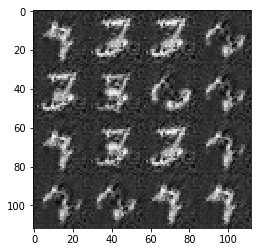

Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 3.5634
Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 5.7122
Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 2.6171
Epoch 2/2... Discriminator Loss: 0.3444... Generator Loss: 4.6887
Epoch 2/2... Discriminator Loss: 0.3527... Generator Loss: 4.1056
Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 4.1424
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 10.4119
Epoch 2/2... Discriminator Loss: 0.4370... Generator Loss: 6.8000
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.4294
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 3.3880


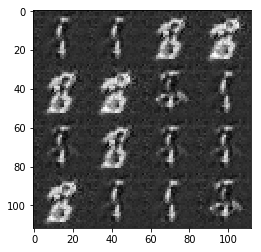

Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 4.6498
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.4568
Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 3.8178
Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 3.7814
Epoch 2/2... Discriminator Loss: 0.3712... Generator Loss: 4.2605
Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 2.6322
Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 3.9496
Epoch 2/2... Discriminator Loss: 0.3800... Generator Loss: 3.4229
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 3.2414
Epoch 2/2... Discriminator Loss: 0.3835... Generator Loss: 5.1079


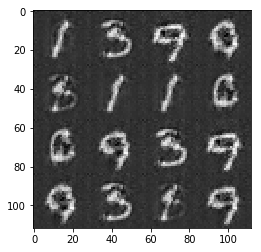

Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 5.6910
Epoch 2/2... Discriminator Loss: 0.3626... Generator Loss: 3.8871
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 3.8563
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 4.6756
Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 4.3085
Epoch 2/2... Discriminator Loss: 0.4813... Generator Loss: 3.3295
Epoch 2/2... Discriminator Loss: 0.4532... Generator Loss: 5.0649
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 3.3976
Epoch 2/2... Discriminator Loss: 0.3579... Generator Loss: 4.7764
Epoch 2/2... Discriminator Loss: 0.3527... Generator Loss: 4.7287


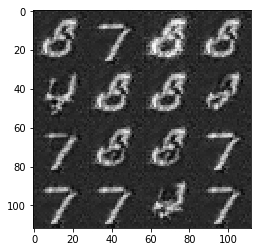

Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 3.4966
Epoch 2/2... Discriminator Loss: 0.4179... Generator Loss: 3.1489
Epoch 2/2... Discriminator Loss: 0.3766... Generator Loss: 5.2076
Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 4.3621
Epoch 2/2... Discriminator Loss: 0.3694... Generator Loss: 3.7950
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 4.7753
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 3.3805
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 2.6866
Epoch 2/2... Discriminator Loss: 0.3612... Generator Loss: 4.1128


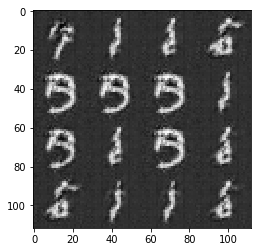

Epoch 2/2... Discriminator Loss: 0.3507... Generator Loss: 4.4432
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 5.0671
Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 6.8949
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 4.0975
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 2.4449
Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 2.9165
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 3.1726
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 4.2476
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 4.4733
Epoch 2/2... Discriminator Loss: 0.3558... Generator Loss: 4.3064


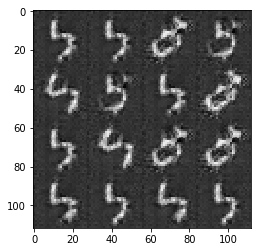

Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 4.8929
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 4.8309
Epoch 2/2... Discriminator Loss: 0.3466... Generator Loss: 4.5800
Epoch 2/2... Discriminator Loss: 0.4988... Generator Loss: 4.3150
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 3.7963
Epoch 2/2... Discriminator Loss: 0.4172... Generator Loss: 2.8380
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 3.8971
Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.4410... Generator Loss: 4.2663
Epoch 2/2... Discriminator Loss: 0.5242... Generator Loss: 2.8698


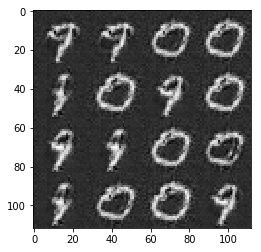

Epoch 2/2... Discriminator Loss: 0.3713... Generator Loss: 4.6663
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 2.9899
Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 4.4810
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.1175
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 3.9152
Epoch 2/2... Discriminator Loss: 0.3988... Generator Loss: 4.0030
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 4.1314


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2342... Generator Loss: 0.0096
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 3.8186
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 4.8355
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 8.2159
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 12.8441
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 8.1270
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 12.7414
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 8.7005
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 3.6030
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.4300


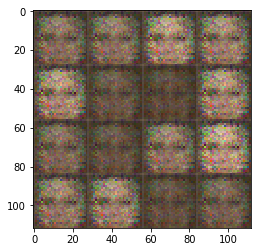

Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 5.6654
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 3.3448
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 6.0857
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.2311
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.6943... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9457


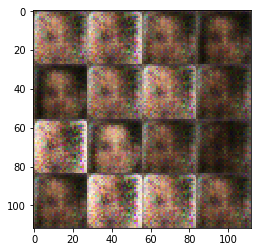

Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 2.7239
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 3.4076
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.7524


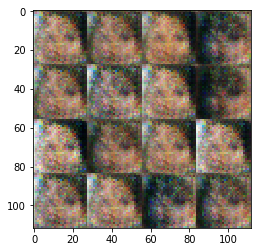

Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.8416
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 2.8223
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 2.1491
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.7517
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.9280


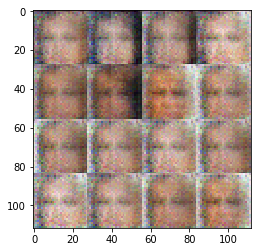

Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.9095
Epoch 1/1... Discriminator Loss: 2.7171... Generator Loss: 6.2843
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.3921
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 3.0672


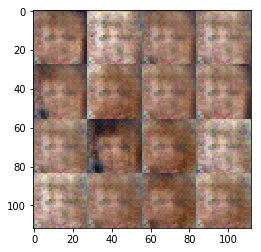

Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.8165
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 4.9913
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.1731
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 1.8384... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.6553


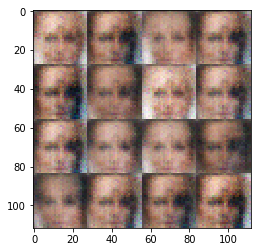

Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 2.4976
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.5526
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 2.4892
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.3839
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 2.3454
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.6057


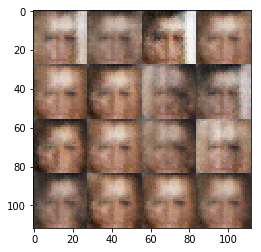

Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 2.2327
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.8946
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.3426


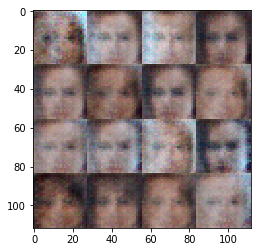

Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 2.2541... Generator Loss: 5.9289
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 2.8795


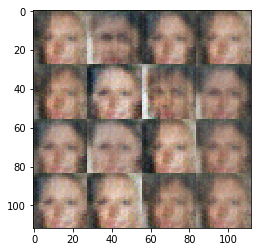

Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.5676
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 2.5835
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 2.1212
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.5556


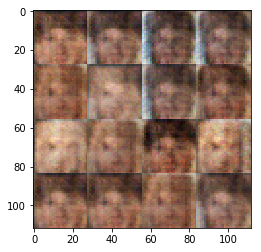

Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 2.0834
Epoch 1/1... Discriminator Loss: 1.8726... Generator Loss: 0.2760
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 2.2523
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.0493


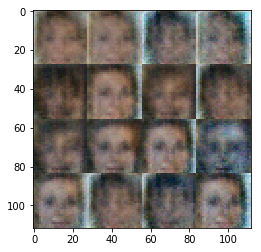

Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 2.6418
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 1.7851
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 4.4158
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 2.4538
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 2.5936


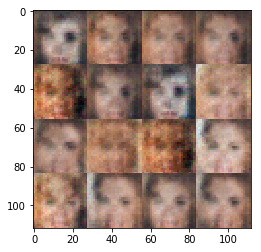

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 3.6988
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 2.4578
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.6856


In [13]:
batch_size = 160
z_dim = 256
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.